## Notebook to create the matrix with 60y with day taken every **5** days with normalization and pca altready applied

OUTPUT : quantities computed over the dataset 60y_JUMP (we have taken days= 1,6,11,16,21,26)
-  _ipca_ saved as ipca_60y.pkl for further use
- _global_mean_ saved as global_mean_60y.npy
- _global_std_ saved as global_std_60y.npy


In [10]:
import sys
import os 
sys.path.append(os.path.abspath(".."))
import xarray as xr
import numpy as np
import gc
import joblib
import warnings
warnings.filterwarnings('ignore')

import importlib
import utils.data_processing
import utils.visualization
importlib.reload(utils.data_processing)
importlib.reload(utils.visualization)

# Import the functions 
from utils.data_processing import prepare_data_matrix, apply_global_standardization, perform_incremental_pca
from utils.visualization import plot_variance



In [2]:
# Carica solo la variabile 't'
ds_t = xr.open_dataset('era5_1961_2020_t850_z500-S.grib', engine='cfgrib', filter_by_keys={'shortName': 't'})
t_850 = ds_t['t']

print(list(ds_t.data_vars.keys()))

# Carica solo la variabile 'z'
ds_z = xr.open_dataset('era5_1961_2020_t850_z500-S.grib', engine='cfgrib', filter_by_keys={'shortName': 'z'})
z_500 = ds_z['z']

print(list(ds_z.data_vars.keys()))



['t']
['z']


In [3]:
# Load the shortened datset
# Unisci in un unico dataset
t_850 = t_850.reset_coords('isobaricInhPa', drop=True)
z_500 = z_500.reset_coords('isobaricInhPa', drop=True)
ds_filtered = xr.Dataset({
    't': t_850,
    'z': z_500
})
print("Overview of the combined dataset:")
print(f"   • Variables: {list(ds_filtered.data_vars.keys())}")
print(f"   • Coordinates: {list(ds_filtered.coords.keys())}")
print(f"   • Shape: {ds_filtered.dims}")

Overview of the combined dataset:
   • Variables: ['t', 'z']
   • Coordinates: ['number', 'time', 'step', 'latitude', 'longitude', 'valid_time']
   • Shape: FrozenMappingWarningOnValuesAccess({'time': 4320, 'latitude': 201, 'longitude': 321})


In [4]:
print(f"Filtered Dataset - Variables: {list(ds_filtered.data_vars.keys())}")
print(f"Dimensions: {dict(ds_filtered.dims)}")
print(f"Time range: {ds_filtered.time.min().values} to {ds_filtered.time.max().values}")

print(ds_filtered)  

print("-----------------")
    
X, data_matrices = prepare_data_matrix(ds_filtered) 


Filtered Dataset - Variables: ['t', 'z']
Dimensions: {'time': 4320, 'latitude': 201, 'longitude': 321}
Time range: 1961-01-01T00:00:00.000000000 to 2020-12-26T00:00:00.000000000
<xarray.Dataset> Size: 2GB
Dimensions:     (time: 4320, latitude: 201, longitude: 321)
Coordinates:
    number      int64 8B 0
  * time        (time) datetime64[ns] 35kB 1961-01-01 1961-01-06 ... 2020-12-26
    step        timedelta64[ns] 8B 00:00:00
  * latitude    (latitude) float64 2kB 70.0 69.75 69.5 69.25 ... 20.5 20.25 20.0
  * longitude   (longitude) float64 3kB -40.0 -39.75 -39.5 ... 39.5 39.75 40.0
    valid_time  (time) datetime64[ns] 35kB 1961-01-01 1961-01-06 ... 2020-12-26
Data variables:
    t           (time, latitude, longitude) float32 1GB ...
    z           (time, latitude, longitude) float32 1GB ...
-----------------
Processing t...
     → t: ('time', 'latitude', 'longitude') → (4320, 64521)
Processing z...
     → z: ('time', 'latitude', 'longitude') → (4320, 64521)

Combined matrix shape: (

In [5]:
print("GLOBAL STANDARDIZATION")

# Apply global standardization
X, global_mean, global_std = apply_global_standardization(X)

print("Before standardization:")
print(f" • Global mean: {global_mean:.2f}m")
print(f" • Global std: {global_std:.2f}m")
print(f"Dataset shape: {X.shape}")


print("After standardization:")
print(f" • New global mean: {X.mean():.6f}")
print(f" • New global std: {X.std():.6f}")

# Verify some sample statistics
print(f" • Sample min: {X.min():.3f}")
print(f" • Sample max: {X.max():.3f}")

GLOBAL STANDARDIZATION
Before standardization:
 • Global mean: 27739.86m
 • Global std: 27510.69m
Dataset shape: (4320, 129042)
After standardization:
 • New global mean: 0.000218
 • New global std: 0.999848
 • Sample min: -1.000
 • Sample max: 1.136


In [6]:
# Save mean and std
np.save("Mid_result_to_save/global_mean_60y.npy", global_mean)
np.save("Mid_result_to_save/global_std_60y.npy", global_std)

In [7]:
print("INCREMENTAL PCA ANALYSIS")

n_components = 20  # Reduced to 20 components for safety with batch processing
batch_size = 100    # Increased batch size to accommodate more components

print(f"   • Target components: {n_components}")
print(f"   • Batch size: {batch_size}")
 
X_pca, ipca, explained_variance_ratio, cumulative_variance = perform_incremental_pca(X, n_components=n_components, batch_size=batch_size)

INCREMENTAL PCA ANALYSIS
   • Target components: 20
   • Batch size: 100
Original shape: (4320, 129042)
PCA shape: (4320, 20)

First 10 components variance: [0.48137999 0.11811535 0.09686092 0.074319   0.05412543 0.03387406
 0.02223438 0.02119103 0.01360827 0.0109053 ]
Total explained variance 20 components cumulative: 0.976


VARIANCE VISUALIZATION


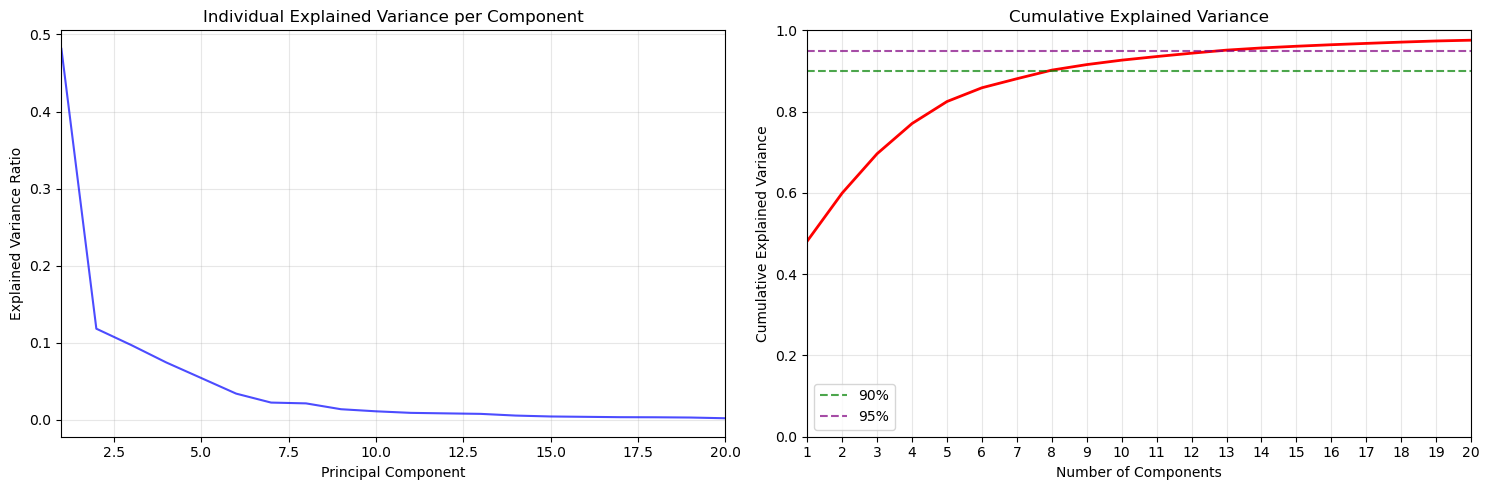

In [11]:
# Visualization of explained variance
print("VARIANCE VISUALIZATION")

# Create plots for variance analysis
plot_variance(explained_variance_ratio, cumulative_variance, n_components)

In [8]:
# Save the PCA model

joblib.dump(ipca, "Mid_result_to_save/ipca_60y.pkl")

['Mid_result_to_save/ipca_60y.pkl']